
Statistics for Base simulation:
                                mean        max       min            std
Zona1_wall2_shade_FMU      0.000000        0.0      0.00       0.000000
Zona1_wall8_shade_FMU      0.000000        0.0      0.00       0.000000
Zona1_wall9_shade_FMU      0.000000        0.0      0.00       0.000000
Zona2_wall2_shade_FMU      0.000000        0.0      0.00       0.000000
Zona2_wall3_shade_FMU      0.000000        0.0      0.00       0.000000
Zona4_wall2_shade_FMU      0.000000        0.0      0.00       0.000000
T_ext                     13.691581       31.2     -1.85       6.271152
Tair_z1                   22.314365       31.1     13.50       3.335846
Tair_z2                   21.020856       28.6     13.40       3.120289
Tair_z3                   21.348481       28.0     13.70       2.855280
Tair_z4                   21.712017       28.4     13.50       3.016622
DistrictCooling        19303.809392  1806922.0      0.00  135305.529490
DistrictHeating        66405.5

<Figure size 640x480 with 0 Axes>

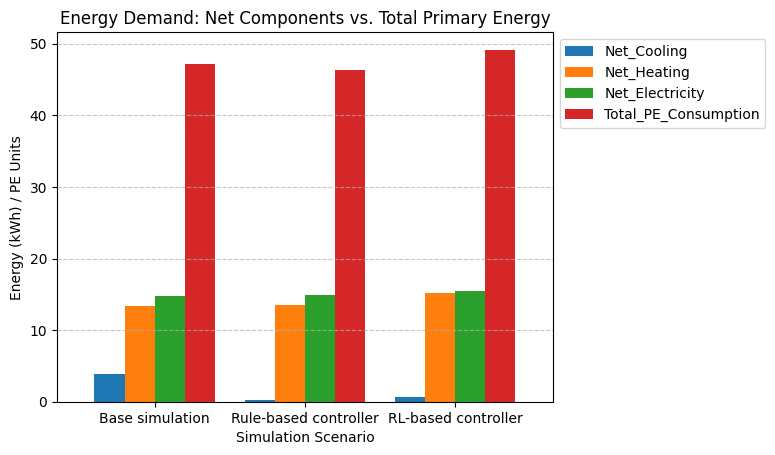

<Figure size 640x480 with 0 Axes>

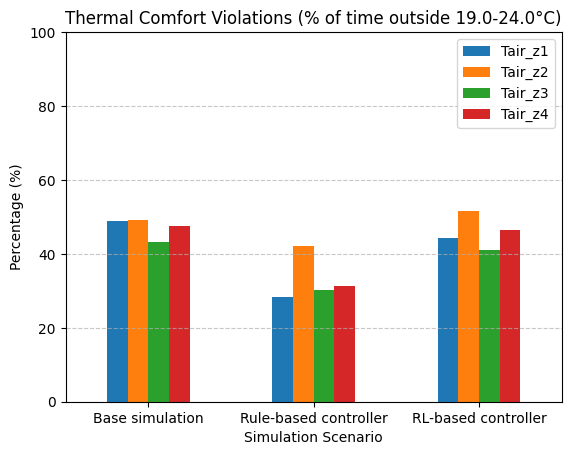

<Figure size 640x480 with 0 Axes>

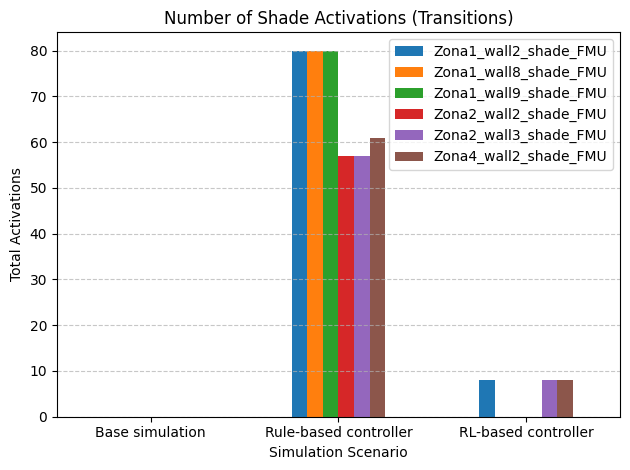

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# List your file paths here
folder_path = './Simulation_results/'
file_paths = [f'{folder_path}Base_Sim/base_simulation.csv', f'{folder_path}Simple_Sim/simple_controller.csv', f'{folder_path}RL_Sim/rl_controller.csv']
labels = ['Base simulation', 'Rule-based controller', 'RL-based controller']

# Configuration
PE_GAS = 1.00
PE_ELEC = 2.17
COP_H = 0.98
EER_C = 5.4
Th = 19.0
Tc = 24.0

def clean_header(col_name):
    """Extracts the 'name' value from the simulation strings."""
    if '{ name:' in col_name:
        return col_name.split('{ name: ')[1].split(' }')[0]
    return col_name

def process_files(paths, names):
    energy_results = []
    comfort_results = []
    shade_results = []
    for path, label in zip(paths, names):
        # Load data (handling the quoted headers)
        df = pd.read_csv(path, quotechar='"')
        
        # Clean headers
        df.columns = [clean_header(c) for c in df.columns]
        
        # Convert Time to datetime and set as index
        df['Time'] = pd.to_datetime(df['Time'])
        df.set_index('Time', inplace=True)
        
        # Compute statistics (Mean, Max, Min, Std)
        stats = df.describe().T[['mean', 'max', 'min', 'std']]
        print(f"\nStatistics for {label}:\n", stats)

        # Energy Demand
        net_cooling = df['DistrictCooling'].abs().sum() / 3.6e6  # Convert from J to kWh
        net_heating = df['DistrictHeating'].abs().sum() / 3.6e6  # Convert from J to kWh
        net_electricity = df['Electricity'].sum() / 3.6e6  # Convert from J to kWh
        total_pe = (net_cooling / EER_C) * PE_ELEC + (net_heating / COP_H) * PE_GAS + net_electricity * PE_ELEC
        energy_results.append({'label': label, 'Net_Cooling': net_cooling, 'Net_Heating': net_heating, 'Net_Electricity': net_electricity, 'Total_PE_Consumption': total_pe})

        # Thermal Comfort
        temp_cols = [c for c in df.columns if 'Tair_z' in c]
        # Count time steps where temperature is outside [Th, Tc]
        violations = ((df[temp_cols] < Th) | (df[temp_cols] > Tc)).sum()
        violations['label'] = label
        # Get percentage of violations
        violations_percentage = violations.copy()
        for col in temp_cols:
            violations_percentage[col] = (violations[col] / len(df)) * 100
        comfort_results.append(violations_percentage)

        # Shade Activations
        shade_cols = [c for c in df.columns if 'shade_FMU' in c]
        # Count transitions from 0 to 7
        activations = (df[shade_cols].diff() > 0).sum()
        activations['label'] = label
        shade_results.append(activations)

    # --- Visualization ---

    # 1. Energy Demand Plot (Net components + Total PE)
    plt.figure()
    energy_df = pd.DataFrame(energy_results).set_index('label')
    energy_df.plot(kind='bar', rot=0, width=0.8)
    plt.title('Energy Demand: Net Components vs. Total Primary Energy')
    plt.ylabel('Energy (kWh) / PE Units')
    plt.xlabel('Simulation Scenario')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    # Move legend to the side so it doesn't cover bars
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

    # 2. Comfort Violations (Percentage)
    plt.figure()
    comfort_df = pd.DataFrame(comfort_results).set_index('label')
    comfort_df.plot(kind='bar', rot=0)
    plt.title(f'Thermal Comfort Violations (% of time outside {Th}-{Tc}°C)')
    plt.ylabel('Percentage (%)')
    plt.xlabel('Simulation Scenario')
    plt.ylim(0, 100) # Since it's percentage
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # 3. Shade Usage
    plt.figure()
    shade_df = pd.DataFrame(shade_results).set_index('label')
    shade_df.plot(kind='bar', rot=0)
    plt.title('Number of Shade Activations (Transitions)')
    plt.ylabel('Total Activations')
    plt.xlabel('Simulation Scenario')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()

process_files(file_paths, labels)